In [8]:
import hydra
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
from omegaconf import OmegaConf
from jaxman.env.pick_and_delivery.env import JaxPandDEnv
from jaxman.utils import compute_agent_action
from jaxman.utils import compute_agent_action
from jaxman.planner.rl_planner.agent.sac.sac import create_sac_agent
from jaxman.planner.rl_planner.agent.dqn.dqn import create_dqn_agent
from flax.training import checkpoints
config = hydra.utils.instantiate(OmegaConf.load("../scripts/config/env/pick_and_delivery/grid.yaml"))
model_config = hydra.utils.instantiate(OmegaConf.load("../scripts/config/model/dqn.yaml"))
config.level=0
config.map_size=10
config.num_agents=1
config.num_items=5
config.dist_reward=0
config.comm_r=4
config.is_crash=False
env = JaxPandDEnv(config)
# plt.imshow(env.render())
key = jax.random.PRNGKey(0)

In [9]:
agent, key = create_dqn_agent(env.observation_space, env.act_space, model_config, key)
actor = agent.actor
actor = checkpoints.restore_checkpoint(
    ckpt_dir="../model/pick_and_delivery/",
    target=actor,
    prefix="grid_actor",
)

In [10]:
ACTION_DICT = {
    "STAY": 0,
    "RIGHT": 1,
    "LEFT": 2,
    "DOWN": 3,
    "UP": 4,
    "LOAD": 5,
    "UNLOAD": 5,
}

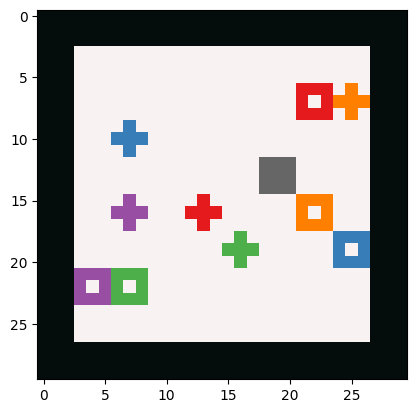

In [11]:
plt.imshow(env.render())

stay, right, left, down, up, load/unload
rew:[0.], act:[1], done:[False]
rew:[0.], act:[1], done:[False]
rew:[0.], act:[1], done:[False]
rew:[0.], act:[1], done:[False]
rew:[0.], act:[1], done:[False]
rew:[0.], act:[1], done:[False]
rew:[0.], act:[1], done:[False]
rew:[0.], act:[1], done:[False]
rew:[0.], act:[1], done:[False]
rew:[0.], act:[1], done:[False]


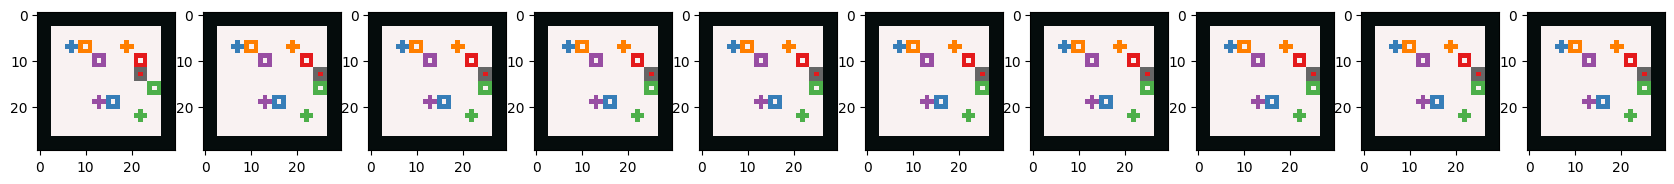

In [12]:
key, subkey = jax.random.split(key)
obs = env.reset(subkey)

is_item_loaded = jnp.expand_dims(jnp.arange(env.num_items) < env.num_agents, -1)
item_starts = (env.task_info.item_starts + is_item_loaded * 10000).astype(int)
env.state = env.state._replace(load_item_id=jnp.arange(env.num_agents), item_pos = item_starts)
fig, axes = plt.subplots(1, 10, figsize=(21, 3))
print("stay, right, left, down, up, load/unload")
for i in range(10):
    key, subkey = jax.random.split(key)
    #compute agent action
    obs = obs.split_observation()
    q_value = actor.apply_fn({"params":actor.params}, obs)
    actions = jnp.argmax(q_value,axis=-1)
    # print(f"q_value:{q_value[0]} max_q_value:{jnp.max(q_value)}")
    # print(f"probability:{q_value[0]/jnp.sum(q_value)}")

    # actions = jax.random.choice(subkey, 6, (config.num_agents,))
    actions = compute_agent_action(["RIGHT"])
    obs, rew, done, trial_info = env.step(actions)
    print(f"rew:{rew}, act:{actions}, done:{done}")
    axes[i].imshow(env.render())

# _observe(state, task_info, trial_info)

In [31]:
jnp.set_printoptions(precision=3)

rew:[0.], act:[5], done:[False]
item info:[[[  -4    1    4    5]
  [9995 9997    6    2]
  [   3   -1    7    6]
  [   0    1    2    3]]], goal:[[6 2]], hold:[[1]], mask:[[ True False  True  True]]


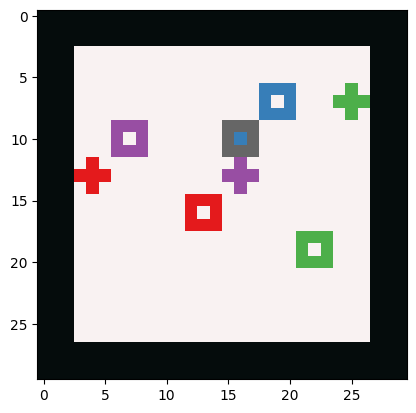

In [22]:

actions = compute_agent_action(["LOAD"])
# actions = compute_agent_action([LOAD"RIGHT","LEFT"])
obs, rew, done, trial_info = env.step(actions)
print(f"rew:{rew}, act:{actions}, done:{done}")
print(f"item info:{obs.item_info}, goal:{obs.item_goals}, hold:{obs.is_hold_item}, mask:{obs.item_masks}")
plt.imshow(env.render())

In [25]:
sac, key = create_sac_agent(env.observation_space,env.action_space, model_config, key)

/home/asano/jaxman/.venv/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


In [26]:
actor = sac.actor

In [17]:
obs = obs._replace(is_hold_item=jnp.array([[900]]))

In [20]:
obs

AgentObservation(agent_state=AgentState(pos=DeviceArray([[5, 4]], dtype=int32), rot=DeviceArray([[0]], dtype=int32), vel=DeviceArray([[0]], dtype=int32), ang=DeviceArray([[0]], dtype=int32)), obs_scans=DeviceArray([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
              0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
              0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
              1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
              0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
              1., 1., 1., 1., 1., 1.]], dtype=float32), is_hold_item=DeviceArray([[900]], dtype=int32), relative_positions=DeviceArray([[[0, 0]]], dtype=int32), intentions=DeviceArray([[[0, 0]]], dtype=int32), item_info=DeviceArray([[[9999, 9998,    4,    2],
              [9995, 9996,    5,    5],
              [   2,    1,    6,    5],
              [  -3,   -2,    4,    4],
              [  -2,    3,    7,    3]]], dtype=

In [18]:
obs.cat()

DeviceArray([[ 5.000e+00,  4.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
               1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
               0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,
               0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
               0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,
               0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
               1.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
               0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
               0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
               0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
               1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
               0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,
               0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,
               0.000e+00,  0.000e+00, 

In [21]:
total_comm_dim = 1 * 4
mask_dim = 1
total_item_dim = 5 * 4
item_mask_dim = 5

In [23]:
obs.cat()[:, -3-total_comm_dim - mask_dim - total_item_dim - item_mask_dim]

DeviceArray([900.], dtype=float32)